In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
from jax import numpy as jnp
from jax.experimental import host_callback

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt
from pprint import pprint

from flax import linen as nn
from typing import Sequence

from functools import partial
from typing import Callable, Sequence
from flax import struct
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial
import numpy as np

import actions
import qlearning
import replay
import plotting
from utils import ConvNet, Transition
from frozen_lake import EnvState, FrozenLake, ObsType, ActType, RNGKey

from mango_utils import MultiDQLTrainState
from mango_utils import eps_greedy_rollout, aggregate

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
seed = 42
map_size = 4
map_scale = int(jnp.log2(map_size))

# hyperparams
# lr fixed to 1e-3
max_interactions = 64 * 1000
rollout_length = 64  # * (map_size ** 2 --- map_size ** 3)
n_rollouts = max_interactions // rollout_length
train_iter = 8  # *

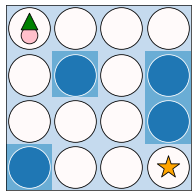

In [4]:
env = FrozenLake.make(None, (map_size, map_size))
env_state, obs = env.reset(jax.random.PRNGKey(0))
plotting.render(env, env_state)

In [5]:
n_actions = 5
n_layers = map_scale
rng = jax.random.PRNGKey(0)

MultiConvNet = nn.vmap(
    ConvNet,
    in_axes=None,
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_actions,
)
MultiLayerConvNet = nn.vmap(
    MultiConvNet, in_axes=0, variable_axes={"params": 0}, split_rngs={"params": True}
)
cells = jnp.array([(2**i, 2**i) for i in reversed(range(1, map_scale + 1))])
dql_state = MultiDQLTrainState.create(
    rng,
    MultiLayerConvNet([16] * map_scale, n_actions),
    obs=jnp.stack([obs] * n_layers),
    beta_fn=partial(actions.beta_fn, cells),
)

In [6]:
epsilons = jnp.ones((map_scale,)).at[-1].set(0.2)
transitions = eps_greedy_rollout(env, dql_state, rng, epsilons, 2)
replay_memory = replay.CircularBuffer.create(transitions)

In [7]:
from typing import NamedTuple


class Results(NamedTuple):
    eval_reward: jax.Array
    eval_done: jax.Array
    expl_reward: jax.Array
    expl_done: jax.Array


def loop_body(carry, rng_loop_iter):
    mango_dql_state, replay_memory = carry
    # bind progress bar update host callback to rng_key split
    rng_expl, rng_train, rng_eval = host_callback.id_tap(
        lambda a, t: pbar.update(1), jax.random.split(rng_loop_iter, 3)
    )

    # exploration rollout
    expl_transitions = eps_greedy_rollout(env, mango_dql_state, rng_expl, epsilons, rollout_length)
    replay_memory = replay_memory.push(expl_transitions)

    # policy training
    for rng_sample in jax.random.split(rng_train, train_iter):
        train_transitions = replay_memory.sample(rng_sample, rollout_length)
        mango_dql_state = mango_dql_state.update_params(train_transitions)

    # evaluation rollout
    eval_transitions = eps_greedy_rollout(
        env, mango_dql_state, rng_eval, jnp.zeros_like(epsilons), rollout_length
    )

    # step results
    step_results = Results(
        eval_transitions.rewards,
        eval_transitions.done,
        expl_transitions.rewards,
        expl_transitions.done,
    )
    return (mango_dql_state, replay_memory), step_results


pbar = tqdm(total=n_rollouts)
(dql_state, replay_memory), results = jax.lax.scan(
    f=loop_body,
    init=(dql_state, replay_memory),
    xs=jax.random.split(rng, n_rollouts),
)
pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

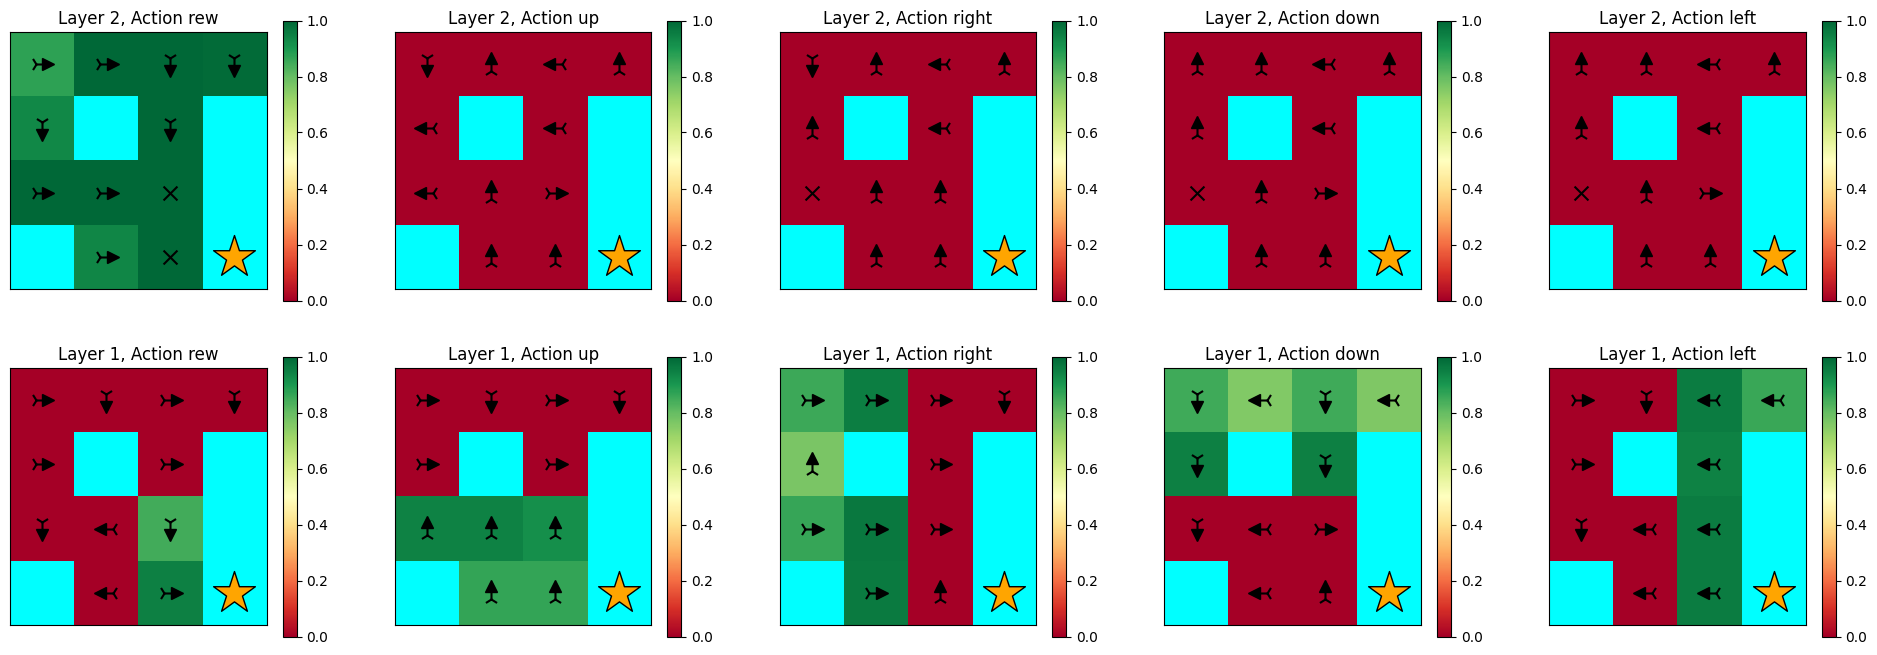

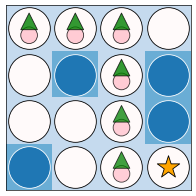

In [8]:
plt.figure(figsize=((n_actions + 1) * map_size, n_layers * map_size))
for i in range(n_layers):
    for j in range(5):
        plt.subplot(n_layers, n_actions, i * n_actions + j + 1)
        plt.title(f'Layer {n_layers-i}, Action {["rew","up","right","down","left"][j]}')
        apply = lambda params, obs: dql_state.qval_apply_fn(
            params, jnp.repeat(obs[jnp.newaxis], n_layers, axis=0)
        )[i, 4 - j]
        plotting.plot_qvals(env, apply, dql_state.params_qnet, hold=True, autoscale=False)
plt.show()

transitions = eps_greedy_rollout(env, dql_state, rng, jnp.zeros_like(epsilons), rollout_length)
plotting.render(env, transitions.env_state)